In [1]:
#General
import numpy as np
import pandas as pd 
import glob
import imageio
import matplotlib.pyplot as plt
import os

#For keras/tf
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

#other:
from numpy.random import randn
from numpy.random import randint
import time
from IPython import display
import cv2
!pip install imutils
from imutils import paths

#Solves an issue with training part (mainly on colab):
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#set seed
np.random.seed(42)
tf.random.set_seed(42)

2024-05-02 05:13:26.558737: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 05:13:28.989828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 05:13:35.270150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Settings 
class settings:
    debug = False
    imsize = 64
    rgb = True
    latent_dim = 256
    n_samples = 0 
    n_epochs = 25
    batch_size = 16

    if rgb:
        channels = 3
    else:
        channels = 1
        
    if debug:
        n_epochs = 70 

In [3]:
def plotExampleImage(img_n):
    img = cv2.imread(impaths[img_n])
    np.shape(img)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))    
    plt.axis('off')

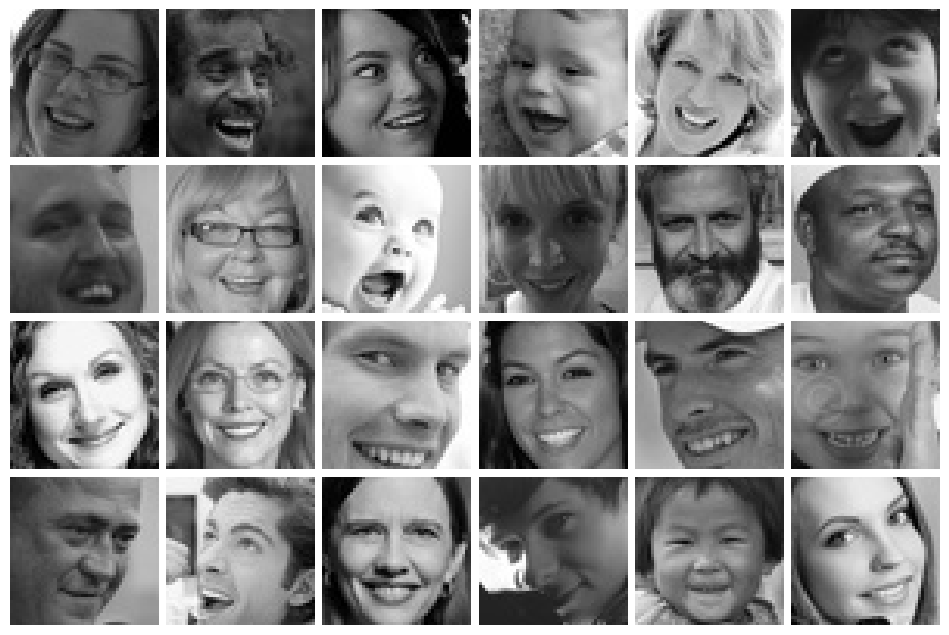

In [4]:
# Get image paths:
impaths = list(paths.list_images("/home/banand_umassd_edu/FER2013/train/happy"))

#Plot example images from the train set:
plt.figure(figsize=(12,8))
for k in range(24):
    plt.subplot(4,6,k+1)
    plotExampleImage(k)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [5]:
ds = []
if settings.debug:
    settings.n_samples = 16*settings.batch_size #Limit the number of images when debugging 
else:
    settings.n_samples = len(impaths)

for i in range(0,settings.n_samples):  
    image = cv2.imread(impaths[i])
    if settings.rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)   
    image = cv2.resize(image, (settings.imsize,settings.imsize))
    ds.append(image)
    
# Convert to array and normalize to [-1, 1]:
train_images = np.array(ds)
train_images = train_images.reshape(train_images.shape[0],64,64,3)
train_images = (train_images - 127.5) / 127.5 

# Convert to tf.dataset:
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(settings.batch_size)

2024-05-02 05:14:20.358770: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
def define_discriminator(in_shape=(settings.imsize,settings.imsize,settings.channels)):
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    model = tf.keras.Sequential(name='Discriminator')
    model.add(Conv2D(256, (5,5), padding='same', input_shape=in_shape,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
  
    model.add(Flatten())
    model.add(Dropout(0.05))
    model.add(Dense(1, activation='sigmoid',kernel_initializer=init))
    return model

In [7]:
def define_generator(latent_dim):
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = tf.keras.Sequential(name='Generator')
    
    n_filters = 128 * 8 * 8
    model.add(Dense(n_filters, input_dim=latent_dim,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
 
    model.add(Conv2DTranspose(256, (4,4), strides=(1,1), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(256, (4,4), strides=(1,1), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Output layer:
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same',use_bias=False))
    return model

In [8]:
def generator_loss(fake_output):
    #With label smoothing:
    #return cross_entropy(tf.ones_like(fake_output) +0.2 - np.random.random(fake_output.shape)*0.4, fake_output)
    #Without any label smoothing:
    return cross_entropy(tf.ones_like(fake_output), fake_output) 

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - np.random.random(real_output.shape)*0.2, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output)+ np.clip(-0.2 + np.random.random(fake_output.shape)*0.4,0,None), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

/home/banand_umassd_edu/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/banand_umassd_edu/.local/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/banand_umassd_edu/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


¤¤¤ Generator ¤¤¤:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │     2,105,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,882,304 (26.25 MB)

 Trainable params: 6,863,360 (26.18 MB)

 Non-trainable params: 18,944 (74.00 KB)



¤¤¤ Discriminator ¤¤¤:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 256)    │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,833 (17.98 MB)

 Trainable params: 4,710,529 (17.97 MB)

 Non-trainable params: 2,304 (9.00 KB)

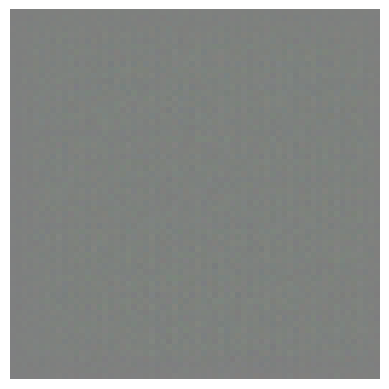

In [10]:
# Define generator and discriminator
generator = define_generator(settings.latent_dim)
discriminator = define_discriminator()

# Optimizer for generator and discriminator:
generator_optimizer     = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5 )

# Define cross-entropy loss:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Visualize one output from the generator
noise = tf.random.normal([1, settings.latent_dim])
generated_image = generator(noise, training=False)
testimg = np.uint8(generated_image[0, :, :, :] * 127.5 + 127.5)
plt.imshow(testimg)
plt.axis('off')

# Visualize the generator and discriminator:
print('¤¤¤ Generator ¤¤¤:')
generator.summary()
print('\n\n¤¤¤ Discriminator ¤¤¤:')
discriminator.summary()

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
noise_dim = settings.latent_dim
num_examples_to_generate = 16 # Generate 16 images
seed = tf.random.normal([num_examples_to_generate, noise_dim]) # Fixed noise seed

In [13]:
tf.config.run_functions_eagerly(True)
@tf.function
def train_step(images):
    noise = tf.random.normal([settings.batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        real_predict = np.array(np.array(real_output)>0.5)
        real_acc = 1-np.sum(np.abs(real_predict-np.ones(np.shape(real_predict)))) /len(real_predict)

        fake_predict = np.array(np.array(fake_output)>0.5)
        fake_acc = 1-np.sum(np.abs(fake_predict-np.zeros(np.shape(fake_predict)))) /len(fake_predict)

        # Chose only the top 1/2 predicted fake images:
        idx = (-fake_output.numpy()).argsort(0).reshape((-1,))

        # Find the 50% highest values, then add a 10% margin so that cases in the begining uses most of the generated images to train the generator:
        gen_loss  = generator_loss(fake_output[fake_output>fake_output[idx[int(len(idx)/2)]]*0.9])
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_acc, fake_acc

In [14]:
def plot_trainingMetrics(G_losses, D_losses, all_gl, all_dl, epoch, real_acc_full, fake_acc_full, all_racc, all_facc, sub_epoch_vect):
    colorG = np.array([195, 60, 162])/255 
    colorD = np.array([61, 194, 111])/255
    colorR = np.array([207, 91, 48])/255
    colorF = np.array([12, 181, 243])/255
    plt.figure(figsize=(10,5))
    plt.title("Generator and discriminator loss for training step {}".format(sub_epoch_vect))
    plt.plot(G_losses,label="Generator",color=colorG)
    plt.plot(D_losses,label="Discriminator",color=colorD)
    plt.xlabel("Iterations in one training step")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(sub_epoch_vect,all_gl,label='Generator',color=colorG)
    plt.plot(sub_epoch_vect,all_dl,label='Discriminator',color=colorD)
    plt.title('All Time Loss')
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title("All Time Accuracy")
    plt.plot(sub_epoch_vect, all_racc,label="Acc: Real",color=colorR)
    plt.plot(sub_epoch_vect, all_facc,label="Acc: Fake",color=colorF)
    plt.xlabel("Iterations")
    plt.ylabel("Acc")
    plt.legend()
    plt.show()

Define the training loop:

In [15]:
def train(dataset, epochs):
    # Store loss and accuracy over time:
    all_gl = np.array([])
    all_dl = np.array([])
    all_racc = np.array([])
    all_facc = np.array([])
    sub_epoch_vect = []

    sub_epoch = 0
    n_batches = train_dataset.cardinality().numpy()
    for epoch in range(epochs):
        print('Starting epoch: ' +str(epoch))
        start = time.time()
        
        G_loss = [] 
        D_loss = []
        real_acc_full = []
        fake_acc_full = []
        global_step = 0
        
        for image_batch in dataset:
            g_loss,d_loss, real_acc, fake_acc = train_step(image_batch)
            global_step = global_step + 1
            sub_epoch = sub_epoch+1
            G_loss.append(g_loss)
            D_loss.append(d_loss)
            real_acc_full.append(real_acc)
            fake_acc_full.append(fake_acc)
            
            # In the beginning, visualize training metrics 
            # and generator output examples more often:
            if epoch<2:
                save_subepoch = 150
            else:
                save_subepoch = 1000
            
            # Plot losses, accuracy and the output examples from the generator
            # Also saves the output example images
            if (sub_epoch % save_subepoch)==0:
                all_gl   = np.append(all_gl,np.mean(np.array([G_loss])))
                all_dl   = np.append(all_dl,np.mean(np.array([D_loss])))
                all_racc = np.append(all_racc,np.mean(np.array([real_acc_full])))
                all_facc = np.append(all_facc,np.mean(np.array([fake_acc_full])))
                sub_epoch_vect=np.append(sub_epoch_vect,sub_epoch)

                # Generate example generator images:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch,
                                        sub_epoch + 1,
                                        seed)
                # Plot training metrics:
                plot_trainingMetrics(G_loss, D_loss, all_gl, all_dl, sub_epoch, real_acc_full, fake_acc_full, all_racc, all_facc, sub_epoch_vect )

                print ('Time for epoch {}, global_step {}, is {} sec'.format(epoch + 1, global_step, time.time()-start))

        # Shuffle dataset after each epoch:
        dataset.shuffle
        
        # Store the weights after each epoch:
        checkpoint.save(file_prefix = checkpoint_prefix)
     
    # Generate example images from the generator after the final epoch:
    generate_and_save_images(generator, epoch,
                                        sub_epoch + 1,
                                        seed)

In [16]:
def generate_and_save_images(model, epoch, sub_epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12, 12))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(np.array(predictions[i, :, :, :]) * 127.5 + 127.5)) 
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}_subepoch{:08d}.png'.format(epoch,sub_epoch))
    plt.show()

In [ ]:
train(train_dataset, settings.n_epochs)

Starting epoch: 0


In [ ]:
anim_file = 'catgan_progress.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

![](catgan_progress.gif)

In [ ]:
def loadCheckpointAndGenerateImages(checkpointNo):
    checkpoint.restore('./training_checkpoints/ckpt-' +str(checkpointNo))
    
    n_sampels_peritt = 64
    n_itt = 16 # generate N batches n_itt times and save the best and worst scores:
    n_images = 16 # save 16 worst and 16 best images
    noise_dim=256

    pred_best  = np.zeros(n_images)
    pred_worst = np.ones(n_images)
    best_images  = np.zeros((n_images,64,64,3))
    worst_images = np.zeros((n_images,64,64,3))
    total_fake_pred = []
    for k in range(n_itt):
        seed_Nimgs = tf.random.normal([n_sampels_peritt, noise_dim])
        generated_images = generator(seed_Nimgs, training=False)
        fake_prediction = discriminator(generated_images, training=False)
        total_fake_pred.append(np.array(fake_prediction))
        idx = (-fake_prediction.numpy()).argsort(0).reshape((-1,))
        idx_nbest  = idx[0:16]
        idx_nworst = idx[-16::]    
        pred_best_temp  = fake_prediction[idx_nbest]
        pred_worst_temp = fake_prediction[idx_nworst]
        best_images_temp  = generated_images[idx_nbest, :,:,:]
        worst_images_temp = generated_images[idx_nworst,:,:,:]

        # Find best images and comapred to previous generated and saved images:    
        for k,x in enumerate(pred_best_temp):
            idx_list = pred_best<np.array(x)      
            if any(idx_list):
                i = idx_list.nonzero()[0][0]
                pred_best[i] = x
                best_images[i,:,:,:] = np.array(best_images_temp[k,:,:,:])

        # Find wrost images and comapred to previous generated and saved images:    
        for k,x in reversed(list(enumerate(pred_worst_temp))):
            idx_list = pred_worst>np.array(x)
            if any(idx_list):
                i = idx_list.nonzero()[0][0]
                pred_worst[i] = x
                worst_images[i,:,:,:] = np.array(worst_images_temp[k,:,:,:])

                
                
    # Plot the 16 random images:
    fig = plt.figure(figsize=(10, 10))
    seed_Nimgs = tf.random.normal([n_sampels_peritt, noise_dim])
    generated_images = generator(seed_Nimgs, training=False)
    fake_prediction = np.array(discriminator(generated_images, training=False))
    fig.suptitle('Examples of random generated images')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(generated_images[i, :, :, :] * 127.5 + 127.5)) 
        plt.text(2,2,'p: {0:.3f}'.format(fake_prediction[i][0]) ,color='y',backgroundcolor='k')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('N_randomImages_final_cp' +str(checkpointNo) +'.png')
    plt.show()
    
    
    # Plot the 16 best images:
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Examples of generated images the discriminator scored high')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(best_images[i, :, :, :] * 127.5 + 127.5)) 
        plt.text(2,2,'p: {0:.3f}'.format(pred_best[i]) ,color='y',backgroundcolor='k')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('N_bestImages_final_cp' +str(checkpointNo) +'.png')
    plt.show()

    # Plot the 16 worst images:
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Examples of generated images the discriminator scored low')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(worst_images[i, :, :, :] * 127.5 + 127.5)) 
        plt.text(2,2,'p: {0:.3f}'.format(pred_worst[i]) ,color='y',backgroundcolor='k')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('N_worstImages_final_cp' +str(checkpointNo) +'.png')
    plt.show()

    # Plot histogram of the scored images
    fig = plt.figure(figsize=(10, 5))
    plt.hist(np.array(total_fake_pred).flatten(),25,color=[0.72,0.30,0.3])
    plt.title('Distribution of discriminator scores on generated images ')
    plt.xlabel('Discriminator Scores')
    plt.savefig('DistributionOfScores' +str(checkpointNo) +'.png')
    plt.show()

In [ ]:
loadCheckpointAndGenerateImages(2)

In [ ]:
loadCheckpointAndGenerateImages(20)

In [ ]:
loadCheckpointAndGenerateImages(25)